## Dependencies

In [1]:
import os
import sys

%load_ext autoreload
%autoreload 2

parent_dir = os.path.split(os.getcwd())[0]
parent_dir

if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    print("Parent dir has been added to sys path.")
else:
    print("Parent dir already exists in sys path")

Parent dir has been added to sys path.


In [221]:
from classes import InvestingComScraper
import pandas as pd
import feedparser
import re
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [171]:
print("Torch version", torch.__version__)
print("CUDA : ", torch.version.cuda)
print("Cuda available : ", torch.cuda.is_available())
print("Torch location : ", torch.__file__)
print("Numpy : ", np.__version__)
print(torch.__config__.show())

Torch version 2.1.2+cpu
CUDA :  None
Cuda available :  False
Torch location :  d:\CodingHenry\nlp_major_move_id\venv\Lib\site-packages\torch\__init__.py
Numpy :  2.3.4
PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CXX_COMPILER=C:/actions-runner/_work/pytorch/pytorch/builder/windows/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /bigobj /FS -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DUSE_FBGEMM -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE /utf-8 /wd4624 /wd4068 /wd4067 /wd4267 /wd4661 /wd4717 /wd4244 /wd4804 /wd4273, LAPACK_INFO=mkl, PERF_WITH_AVX=1, PERF_WITH_AVX2=1, PER

## Data Preprocessing

In [143]:
df = pd.read_csv("../data/raw/stock_news_partial_labeled.csv")
df.info()
df = df.drop(df.columns[0], axis=1)
df = df.rename(columns={"label": "sentiment"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26000 entries, 0 to 25999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  26000 non-null  int64 
 1   headline    26000 non-null  object
 2   label       26000 non-null  object
 3   Importance  499 non-null    object
dtypes: int64(1), object(3)
memory usage: 812.6+ KB


In [144]:
partial_labeled_df = df[df["Importance"].notna()]
partial_labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, 0 to 498
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   headline    499 non-null    object
 1   sentiment   499 non-null    object
 2   Importance  499 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [145]:
partial_labeled_df.head()

,headline,sentiment,Importance
0,Phillips 66 (PSX) Stock Sinks As Market Gains:...,Negative,major
1,5 Dirt Cheap Homebuilder Stocks in 2022,Neutral,minor
2,"Royal Caribbean, Carnival, Norwegian Near Pre-...",Positive,minor
3,ESG Rating Firms Reeling as War Exposes Russia...,Negative,minor
4,Alpa Sutaria Joins WestRock as Senior Vice Pre...,Neutral,minor


In [146]:
partial_labeled_df["Importance"].unique()

array(['major', 'minor', 'neutral', 'minor ', 'major '], dtype=object)

In [147]:
partial_labeled_df["Importance"] = partial_labeled_df["Importance"].str.strip()

C:\Users\User\AppData\Local\Temp\ipykernel_18892\1458290096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_labeled_df["Importance"] = partial_labeled_df["Importance"].str.strip()


In [148]:
partial_labeled_df["Importance"].value_counts()

Importance
minor      273
major      119
neutral    107
Name: count, dtype: int64

In [149]:
partial_labeled_df.sample(10)

,headline,sentiment,Importance
454,Here's Why Investors Should Retain Hawaiian Ho...,Neutral,minor
19,Is Charter Communications (CHTR) a Smart Long-...,Neutral,minor
355,Doug Fabick is out as chairman and CEO of $1B ...,Positive,major
377,Molson Coors Beverage Company Reports 2021 Fou...,Neutral,minor
91,Crown Castle (CCI) Gains As Market Dips: What ...,Neutral,minor
286,HPE CEO details the four key mega trends in te...,Neutral,minor
349,Garmin announces transfer of listing to the Ne...,Positive,major
60,Kay Matthews Becomes Chair of SVB Board of Dir...,Positive,neutral
28,Globe Life's (NYSE:GL) investors will be pleas...,Neutral,neutral
329,Here's Why You Should Hold on to National Visi...,Neutral,major


### Semi-Supervised Labeling with Random Forest Using Feature Extraction (BERT) 

In [188]:
X = partial_labeled_df["headline"]
y = partial_labeled_df["Importance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [189]:
labels, counts = np.unique(y_train, return_counts=True)

for label, count in zip(labels, counts):
  print(label_encoder.classes_[label], count)

major 99
minor 210
neutral 90


In [190]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased").to(device)

def get_embeddings(texts):
  inputs = tokenizer(
    list(texts),
    padding = True,
    truncation = True,
    return_tensors = "pt",
    max_length = 128
  )

  inputs = {k: v.to(device) for k, v in inputs.items()}

  with torch.no_grad():
    outputs = model(**inputs).last_hidden_state[:, 0, :]
  
  return outputs.cpu().detach().tolist()

train_embeddings = get_embeddings(X_train)
test_embeddings = get_embeddings(X_test)
train_embeddings = np.array(train_embeddings, dtype=np.float32)
test_embeddings = np.array(test_embeddings, dtype=np.float32)

d:\CodingHenry\nlp_major_move_id\venv\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# oversampling

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_embeddings, y_train)


In [222]:
print("Resampled class distribution:", Counter(y_resampled))

Resampled class distribution: Counter({np.int64(1): 210, np.int64(0): 210, np.int64(2): 210})


#### RandomForest Classifier

In [196]:
rf = RandomForestClassifier(class_weight="balanced")
rf.fit(X_resampled, y_resampled)
rf.score(test_embeddings, y_test)

0.54

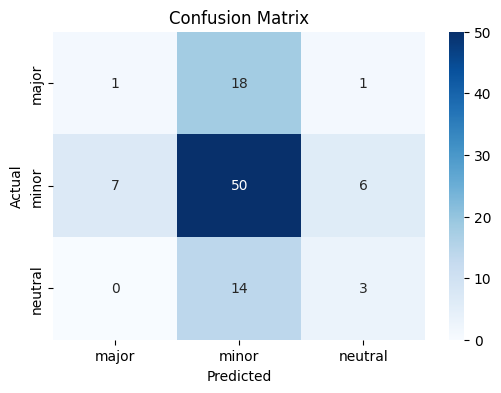

In [211]:
y_pred = rf.predict(test_embeddings)
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [212]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       major       0.12      0.05      0.07        20
       minor       0.61      0.79      0.69        63
     neutral       0.30      0.18      0.22        17

    accuracy                           0.54       100
   macro avg       0.34      0.34      0.33       100
weighted avg       0.46      0.54      0.49       100



#### Logistic Regression Classifier

In [217]:
lg_clf = LogisticRegression(max_iter=2000, class_weight="balanced")
lg_clf.fit(X_resampled, y_resampled)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [218]:
lg_clf.score(test_embeddings, y_test)

0.48

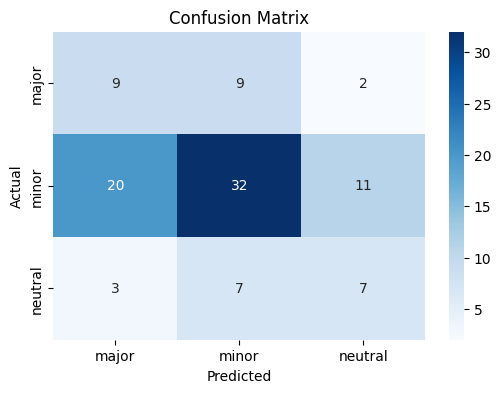

In [219]:
y_pred = lg_clf.predict(test_embeddings)
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [220]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       major       0.28      0.45      0.35        20
       minor       0.67      0.51      0.58        63
     neutral       0.35      0.41      0.38        17

    accuracy                           0.48       100
   macro avg       0.43      0.46      0.43       100
weighted avg       0.54      0.48      0.50       100

